Since the P/E ratio is an very important index for investors to assess if a stock is overvalued, undervalued, or fairly valued compared to its earnings, this function and example is made to show the Time Series visualization of any issuers the inverstors input.



In [1]:
##CONNECTING six-group Api portal with python
import urllib.request
import ssl
import json
from typing import List, Dict, Any

class APIError(Exception):
    def __init__(self, message: str, correlation_id: str = None):
        self.message = message
        self.correlation_id = correlation_id
        super().__init__(message)


class FinancialDataAPI:
    def __init__(self, certificate_path: str):
        self.url = 'https://web.api.six-group.com/api/findata'
        self.headers = {
            "accept": "application/json"
        }
        self.context = ssl.SSLContext()
        self.context.load_cert_chain(f'{certificate_path}/signed-certificate.pem', f'{certificate_path}/private-key.pem')

    def _http_request(self, end_point: str, query_string: Dict[str, Any]) -> Dict[str, Any]:
        """
        Make an HTTP request and send the raw response.
        """
        complete_url = f"{self.url}{end_point}?{urllib.parse.urlencode(query_string)}"
        try:
            request = urllib.request.Request(complete_url, headers=self.headers)
            with urllib.request.urlopen(request, context=self.context) as response:
                return json.loads(response.read())
        except urllib.error.HTTPError as err:
            correlation_id = err.headers.get('X-CorrelationID')
            raise APIError("An error occurred during the API request.", correlation_id) from err

    def _http_request_with_scheme_id(self, end_point: str, scheme: str, ids: List[str]) -> Dict[str, Any]:
        """
        Make an HTTP request using scheme and ids.
        """
        query_string = {
            'scheme': scheme,
            'ids': ",".join(ids)
        }
        return self._http_request(end_point, query_string)

    def instrumentBase(self, scheme: str, instruments: List[str]) -> Dict[str, Any]:
        """
        Retrieve instrument basic attributes using scheme and ids.
        """
        end_point = "/v1/instruments/referenceData/instrumentBase"
        return self._http_request_with_scheme_id(end_point, scheme, instruments)

    def endOfDayHistory(self, scheme: str, listings: List[str], dateFrom: str, dateTo: str = '') -> Dict[str, Any]:
        """
        Retrieve End of Day Timeseries data.
        """
        end_point = "/v1/listings/marketData/endOfDayHistory"
        query_string = {
            'scheme': scheme,
            'ids': ",".join(listings),
            'dateFrom': dateFrom,
            'dateTo': dateTo
        }
        return self._http_request(end_point, query_string)



In [2]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
# Assuming the FinancialDataAPI class is defined elsewhere and imported here

def fetch_and_plot_pe_ratios(api: FinancialDataAPI, scheme: str, identifiers: list, dateFrom: str, dateTo: str = ''):
    """
    Fetches and plots the priceEarningsRatioReported for given identifiers using the FinancialDataAPI.

    :param api: An instance of the FinancialDataAPI to use for data retrieval.
    :param scheme: The scheme for the identifiers (e.g., "ISIN").
    :param identifiers: A list of identifiers of the instruments (e.g., specific ISIN numbers).
    :param dateFrom: The start date for the data range (format YYYY-MM-DD).
    :param dateTo: The end date for the data range (format YYYY-MM-DD). If not provided, defaults to an empty string.
    """
    plt.figure(figsize=(10, 6))

    for identifier in identifiers:  # Loop through each identifier
        try:
            response = api.endOfDayHistory(scheme, [identifier], dateFrom, dateTo)
            if 'data' in response:
                listings = response['data'].get('listings', [])
                dates = []
                price_earnings_ratios = []

                for listing in listings:
                    endOfDayHistory = listing.get('marketData', {}).get('endOfDayHistory', [])
                    for day_data in endOfDayHistory:
                        try:
                            date = datetime.strptime(day_data['sessionDate'], '%Y-%m-%d')
                            pe_ratio = day_data.get('priceEarningsRatioReported', None)
                            if pe_ratio is not None:
                                dates.append(date)
                                price_earnings_ratios.append(pe_ratio)
                        except ValueError as e:
                            print(f"Date format error for {identifier}: {e}")

                if dates and price_earnings_ratios:
                    # Plotting for each identifier
                    plt.plot(dates, price_earnings_ratios, marker='o', linestyle='-', label=identifier)
                else:
                    print(f"No data to plot for {identifier}.")
            else:
                print(f"No data found for identifier: {identifier}")
        except Exception as e:
            print(f"Error fetching or plotting data for {identifier}: {e}")

    # Finalizing the plot
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gcf().autofmt_xdate()

    plt.xlabel('Session Date')
    plt.ylabel('P/E Ratio Reported')
    plt.title('Price-Earnings Ratio Reported Time Series')
    plt.legend()
    plt.tight_layout()
    plt.show()




<ipython-input-10-11f6dd5c5e43>:22: DeprecationWarning: ssl.SSLContext() without protocol argument is deprecated.
  self.context = ssl.SSLContext()
<ipython-input-10-11f6dd5c5e43>:22: DeprecationWarning: ssl.PROTOCOL_TLS is deprecated
  self.context = ssl.SSLContext()


No data to plot for 1222171_4.


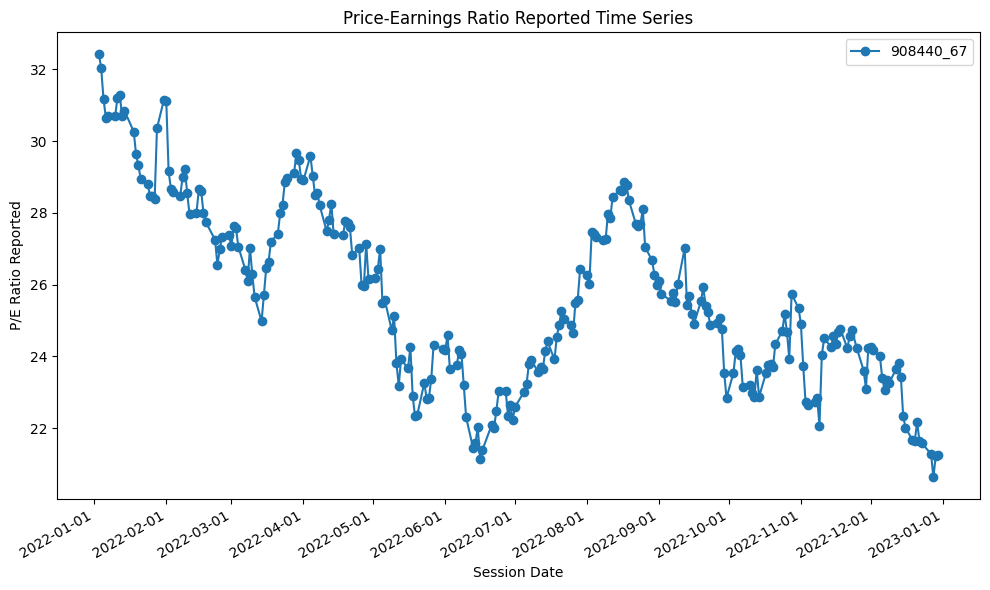

In [ ]:
# Example usage 1
api_instance = FinancialDataAPI('/content/certi')  # Remember to Initialize with your certificate path!
identifiers = ["1222171_4", "908440_67"]  # Example identifiers
fetch_and_plot_pe_ratios(api_instance, "VALOR_BC", identifiers, "2022-01-01", "2022-12-31")

<ipython-input-10-11f6dd5c5e43>:22: DeprecationWarning: ssl.SSLContext() without protocol argument is deprecated.
  self.context = ssl.SSLContext()
<ipython-input-10-11f6dd5c5e43>:22: DeprecationWarning: ssl.PROTOCOL_TLS is deprecated
  self.context = ssl.SSLContext()


No data to plot for 1222171_4.


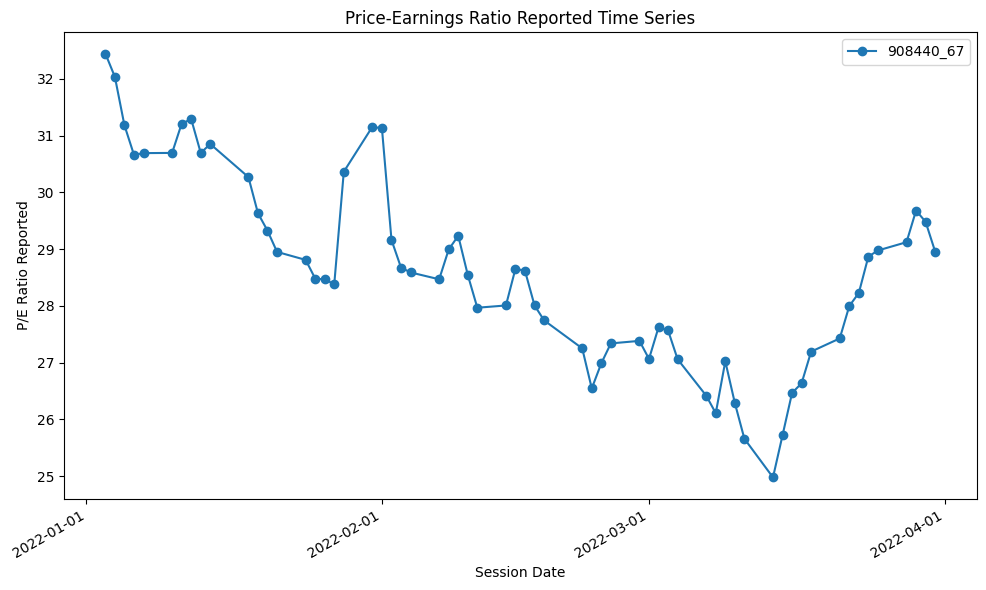

In [ ]:
# Example usage 2
api_instance = FinancialDataAPI('/content/certi')  # Initialize with your certificate path
identifiers = ["1222171_4", "908440_67"]  # Example identifiers
fetch_and_plot_pe_ratios(api_instance, "VALOR_BC", identifiers, "2022-01-01", "2022-03-31")